# Progress Demo 3
`progress3.ipynb`

### Problem
- The bomb is simply dropped with no horizontal velocity
- The observer stands where the bomb is supposed to land.
- Air is of uniform pressure
- Air resistence is ignored
- The whistle is replaced with a nice sound of the appropriate doppler frequency

### Progress
- I tried going to a numeric solution, but that ended up taking far too long to calculate. I have included the code below, but it will probably take more than a day to execute fully. I need a very high sample rate for the sound.
- I instead focused my attention to getting a formula for air density to get an accurate speed for sound for the dopler shift. 

### Possible improvements
- Make the computational solution more efficient.
- Add accuracy to the simulation

### Things to install
```bash
$ conda install moviepy
$ conda remove --force ffmpeg
$ brew install ffmpeg
```

In [1]:
from pylab import *
from numba import jit
from moviepy.editor import VideoClip,AudioFileClip,VideoFileClip
from moviepy.audio.AudioClip import AudioArrayClip
from moviepy.video.io.bindings import mplfig_to_npimage

In [2]:
def timearray(duration,sampleRate = 44100,overshoot=False):
    '''
    Returns a time array.
    '''
    last_full_second = int(floor(duration))
    partial_seconds = duration % 1.0
    second = linspace(0.,1.,sampleRate+1)[1:]
    time = array([0])
    for i in range(last_full_second): 
        time = concatenate((time,i+second))
    partial_second = last_full_second + second[second <= partial_seconds]
    exact_duration = True if \
        (partial_second[-1] if len(partial_second) > 0 else last_full_second)\
        == duration else False
    if overshoot == True and not exact_duration:
        if len(partial_second) == len(second):
            partial_second = concatenate((partial_second,second[0:1]+last_full_second+1))
        elif len(partial_second) == len(second) - 1:
            partial_second = concatenate((partial_second,second[-1:]+last_full_second))
        else:
            lps = len(partial_second)
            partial_second = concatenate((partial_second,second[lps:lps+1]+last_full_second))
    time = concatenate((time,partial_second))
    return time

def rescaleAudio(audio,channels=1):
    '''
    Rescales audio for MoviePy (from -1 to 1)
    '''
    audio = audio - min(audio)
    audio = audio * 2 / max(audio)
    audio = audio - 1
    if shape(audio) == (1):
        audio.reshape((len(audio),1))
        channel = audio[:]
        for i in range(channels-1):
            audio = concatenate((audio,channel),axis=1)
    return audio.reshape((len(audio),1))

## User defined variables

In [3]:
# initial conditions
pos_x_observer = 0. #m
pos_y_observer = 2000. #m
pos_x_object = 0. #m
pos_y_object = 2000. #m
vel_x_object = 400. #m/s
vel_y_object = 0. #m/s
#m = 250. #kg

# audio settings
whistle_frequency = 1440. #Hz
sample_rate = 44100 #Hz (44100)

## Drop Simulation

In [4]:
# sample rate
rate = sample_rate
nyquist = rate/2

# physical constants
g = -9.8 #m/s^2
T0 = 288.16 #K

# mathematical constants
alpha = .0065 # K/m
beta = (2./3.)/alpha*sqrt(1.4*8.314/0.02897)

# variable reassignments
x0 = pos_x_object
v0x = vel_x_object
y0 = pos_y_object
v0y = vel_y_object
xObs = pos_x_observer
yObs = pos_y_observer
x0diff = x0-xObs
y0diff = y0-yObs


# the simulation
drop_time = (-v0y - sqrt(v0y**2 - 2*g*y0))/g
t = timearray(drop_time,rate)
duration = max(t)
one = ones(len(t))
x = v0x*t + x0
y = .5*g*t**2+ v0y*t + y0
vx = g*t + v0x
vy = g*t + v0y
d = sqrt((x-xObs)**2 + (y-yObs)**2)
vObs = (v0x*(v0x*t+x0diff)+(g*t+v0y)*(.5*g*t**2+v0y*t+y0-yObs))/d
sObs = beta*(T0-alpha*yObs)**1.5
s = (beta*(T0-alpha*y)**1.5 - sObs)/(yObs-y)

print 'Drop time: %.5f s' % drop_time
print 'Duration: %.5f s' % duration
print 'Final vel: %.5f m/s' % vObs[-1]

Drop time: 20.20305 s
Duration: 20.20304 s
Final vel: 435.85040 m/s


## Method 1: Frequency and the Doppler Equation

`whistle` is a function which generates a nice sounding whistle. It does so by generating the first six harmonic sine waves with $sin(2 \pi f t)$ and scales them by a factor of $10^{1-n}$ ($1,.1,.01,...$).

The "doplerized" version multiplies the frequency by a factor of $\dfrac{v_s}{v_s + v_o}$, where $v_s$ is the speed of sound and $v_o$ is the velocity of the object. This works because the velocity curve is smooth.

In [5]:
def whistle(f,t) :
    '''
    Creates a nice sounding whistle given a frequency f and a time array t.
    '''
    summ = 0
    for n in range(1,6): summ += (10**(1-n))*sin(n*f*2*pi*t)
    #summ *= 2**13
    summ /= 5
    return summ

** Turn your sound down for this!! **

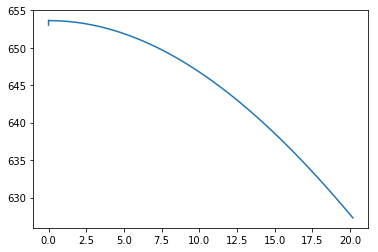

0


In [15]:
f = whistle_frequency
fdop = (s/(s+vObs))*f
sigma = 1/(1+exp((fdop-(sample_rate/2.))*5/30))
m1aud = whistle(fdop,t)
m1aud *= sigma
m1audio = AudioArrayClip(rescaleAudio(m1aud),rate*2)
#m1audio.ipython_display(loop=False,autoplay=False,audio_codec='aac')
plot(t,fdop);show()

## Method 2: Shifting Audio Samples

In [7]:
rawwhistle = whistle(f,t)
dt = d/s
tdop = t + dt
tdop = tdop - tdop[0]
m2aud = interp(t,tdop,rawwhistle)
m2aud *= sigma
m2audio = AudioArrayClip(rescaleAudio(m2aud),rate*2)
m2audio.ipython_display(loop=False,autoplay=False,audio_codec='aac')

100%|██████████| 223/223 [00:00<00:00, 1023.10it/s]


## Visualizations

In [8]:
xmin=min(x)-.01*ptp(x)
xmax=max(x)+.01*ptp(x)
xscale=xmax-xmin
ymin=0-.01*y0
ymax=y0+.01*y0
yscale=ymax-ymin
tmin=min(t)-.01*ptp(t)
tmax=max(t)+.01*ptp(t)
tscale=tmax-tmin

In [9]:
fig = plt.figure(figsize=(7.5,7))
ax = fig.add_subplot(111)
skip = int(ceil(len(t)/40))
def make_frame(timestamp):
    i = len(t) - 1 - argmax(t[::-1] <= timestamp)
    ax.clear()
    ax.set_aspect('equal')
    ax.plot([x[i],x[i]],[ymin,ymax],':c',markersize=5)
    ax.plot([xmin,xmax],[y[i],y[i]],':c',markersize=5)
    ax.plot(x[:i+1:skip], y[:i+1:skip],'.k',alpha=.5)
    ax.plot(x[i], y[i],'ok',markersize=10)
    #ax.text(xmin+.01*xscale, ymin+.05*yscale,' t: %.5fsec \n y: %.5fm' % (t[i],y[i]))
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    #ax.set_xlabel('$x$')
    #ax.set_ylabel('$y$',rotation=0)
    ax.set_title('Bomb Drop')
    return mplfig_to_npimage(fig)

In [10]:
videoclip = VideoClip(make_frame, duration=duration)
audioclip = m1audio
finalclip = videoclip.set_audio(audioclip)
finalclip.ipython_display(fps=30,loop=False,autoplay=False,audio_codec='aac')

100%|██████████| 607/607 [01:34<00:00,  6.81it/s]


In [11]:
finalclip.write_videofile('dropm1.mp4',fps=30,audio_codec='aac')

[MoviePy] >>>> Building video dropm1.mp4
[MoviePy] Writing audio in dropm1TEMP_MPY_wvf_snd.mp4


100%|██████████| 223/223 [00:00<00:00, 353.69it/s]

[MoviePy] Done.
[MoviePy] Writing video dropm1.mp4



100%|██████████| 607/607 [01:43<00:00,  7.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: dropm1.mp4 



In [ ]:
clf()
shift = 30
imin = 1500
imax = imin+shift
incr = 1+1
plot(t[imin:imax:incr],rawwhistle[imin:imax:incr],'o',label='raw data')
plot(tdop[imin:imax:incr],rawwhistle[imin:imax:incr],'o',label='shifted data')
for i in range(imin,imax,incr):
    arrow(t[i], rawwhistle[i], tdop[i]-t[i], 0, head_width=0.001, head_length=0.00001, fc='k', ec='k')
title('Manual Shifting')
xlabel('Amplitude')
ylabel('Time [s]')
legend()
savefig('manshift.png')
show()

In [11]:
print t[fdop == nan]

[]


In [22]:
from scipy.signal import spectrogram
clf()
fspect, tspect, sig = spectrogram(m2aud, fs=rate,window='hanning',
                                  nperseg=1024,noverlap=1024 - 100,
                                  detrend=False, scaling='spectrum')
pcolormesh(tspect, fspect, 10 * log10(sig), cmap='Greys_r')
plot(t,fdop,'r',linewidth=4.0,label='Method 1')
xlim(0,max(t))
fmax = max(fdop[fdop != nan])
print fmax
ylim(0,max(fdop))
ylabel('$f$ [Hz]')
xlabel('$t$ [s]')
title('Frequency of the Two Methods')
savefig('freqplot.png')
show()

nan


ValueError: Axis limits cannot be NaN or Inf

## Numeric Solution

This is my attempt at a numeric solution. As I said, a single pass would take more than a day. I will try to see when I can run it for that long, but I don't know about that.

**DO NOT RUN THIS CODE**

In [ ]:
from ipywidgets import FloatProgress, FloatText, IntText
from IPython.display import display
from traitlets import link

rate = 44100
maxtime = 60 #sec

v0 = array([150.,0.]) #m/s
h0 = 2000. #m
x0 = array([0.,h0]) #m
m = 250. #kg
mu = .1
g = -9.8 #m/s^2
area = .27*pi #m^2
ro = 1.225 #kg/m^3

progress = FloatProgress(min=-h0, max=0, description='progress')
height = FloatText(value=0, description='height')
time = FloatText(value=0, description='time')
iteration = IntText(value=0,description='iteration')
#link((progress,'value'),(height,'value'))
display(progress,height,time,iteration)

@jit
def simulate(rate,maxtime,m,mu,area,v0,x0,g,ro):
    second = linspace(0.,1.,rate+1)[1:]
    maxiter = rate * maxtime 
    #maxiter = 10 
    i = 0
    mg = m*g
    t = 0
    v = v0[:]
    lv = sqrt(sum(v**2))
    uv = v/lv
    fg = array([0.,mg])
    fd = uv * .5 * mu * m * lv**2 * area * ro
    f = fg + fd
    a = f / m
    x = x0[:]
    h = x[1]
    F,Fd,Fg = [f],[fd],[fg]
    T,X,V,A = [t],[x],[v],[a]
    #print i,X[i],type(X),type(X[i]),len(X[i]),X[i][1]
    #while X[i][1] > 0 and i < maxiter:
    while h > 0 and i < maxiter:
        last = i
        i += 1
        t = T[i-1] - T[i-1]%1 + second[i%rate]
        dt = t - T[i-1]
        lv = sqrt(sum(v**2))
        uv = v/lv
        fg = array([0.,mg])
        fd = -uv * .5 * mu * m * lv**2 * area * ro
        f = fg + fd
        a = f / m
        v = v + a*dt
        x = x + v*dt
        h = x[1]
        progress.value = -h
        height.value = h
        time.value = t
        iteration.value = i
        F.append(f)
        Fd.append(fd)
        Fg.append(fg)
        T.append(t)
        X.append(x)
        V.append(v)
        A.append(a)
        #print 'i = %d, t = %.5f, h = %.5f' % (i,t,h)
        '''
        print 'i =',i
        print 'i-1 =',i-1
        print 'dt =',dt
        print 'dt*rate =',dt*rate
        print 'f =',f
        print 'fd =',fd
        print 'fg =',fg
        print 't =',t
        print 'x =',x
        print 'v*dt =',v*dt
        print 'v =',v
        print 'a*dt =',a*dt
        print 'a =',a
        print ' '
        '''
    F,Fd,Fg = array(F),array(Fd),array(Fg)
    T,X,V,A = array(T),array(X),array(V),array(A)    
    return X,V,A,T,F,Fd,Fg
X,V,A,T,F,Fd,Fg = simulate(rate,maxtime,m,mu,area,v0,x0,g,ro)
print m,mu,area,v0,x0,g,ro
t = T
x,y = X.T
print (min(x),max(x)),(min(y),max(y))
print shape(x),shape(X)
plot(x,y)
show()